# 20160221-predict-household-income-from-census

Related post:  
https://stharrold.github.io/20160221-predict-household-income-from-census.html

Data documentation:  
https://www.census.gov/programs-surveys/acs/technical-documentation/pums/documentation.2013.html  
https://usa.ipums.org/usa/volii/2000pumas.shtml  
https://www.census.gov/geo/maps-data/data/gazetteer2000.html  
https://www.census.gov/geo/maps-data/data/gazetteer2010.html  

## Initialization

### Imports

In [1]:
cd ~

/home/samuel_harrold


In [2]:
# Import standard packages.
import collections
import functools
import itertools
import json
import os
import pdb # Debug with pdb.
import pprint
import sys
import time
import warnings
# Import installed packages.
import astroML.density_estimation as astroML_dens # TODO: remove
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sklearn as sk
import sklearn.cross_validation as sk_cv
import sklearn.decomposition as sk_dc
import sklearn.ensemble as sk_ens
import sklearn.metrics as sk_met
import seaborn as sns
# Import local packages.
# Insert current directory into module search path.
# Autoreload local packages after editing.
# `dsdemos` version: https://github.com/stharrold/dsdemos/releases/tag/v0.0.5
sys.path.insert(0, os.path.join(os.path.curdir, r'dsdemos'))
%reload_ext autoreload
%autoreload 2
import dsdemos as dsd
%matplotlib inline

In [3]:
print("Timestamp:")
print(time.strftime(r'%Y-%m-%dT%H:%M:%S%Z', time.gmtime()))
print()
print("Versions:")
print("Python:", sys.version_info)
print("matplotlib:", mpl.__version__)
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("scipy:", scipy.__version__)
print("seaborn:", sns.__version__)
print("sklearn:", sk.__version__)
print("dsdemos:", dsd.__version__)

Timestamp:
2016-02-15T20:53:20GMT

Versions:
Python: sys.version_info(major=3, minor=5, micro=1, releaselevel='final', serial=0)
matplotlib: 1.5.1
numpy: 1.10.4
pandas: 0.17.1
scipy: 0.17.0
seaborn: 0.7.0
sklearn: 0.17
dsdemos: 0.0.5


### Globals

File sources:
* 2013 5-year PUMS data dictionary: [PUMS_Data_Dictionary_2009-2013.txt](http://www2.census.gov/programs-surveys/acs/tech_docs/pums/data_dict/PUMS_Data_Dictionary_2009-2013.txt) (<1&nbsp;MB)
* 2013 5-year PUMS person and housing records for District of Columbia:
    * Person records: [csv_pdc.zip](http://www2.census.gov/programs-surveys/acs/data/pums/2013/5-Year/csv_pdc.zip) (5&nbsp;MB compressed, 30&nbsp;MB decompressed)
    * Housing records: [csv_hdc.zip](http://www2.census.gov/programs-surveys/acs/data/pums/2013/5-Year/csv_hdc.zip) (2&nbsp;MB compressed, 13&nbsp;MB decompressed)
* 2000 Census for District of Columbia:
    * Mapping from PUMA to tract: [2000PUMAsASCII.txt](https://usa.ipums.org/usa/volii/2000PUMAsASCII.txt) (14&nbsp;MB)
    * Gazetteer file for tracts: [ustracts2k.zip](http://www2.census.gov/geo/docs/maps-data/data/gazetteer/ustracts2k.zip) (2&nbsp;MB compressed, 8&nbsp;MB decompressed)
* 2010 Census for District of Columbia:
    * Gazetteer file for PUMAs: [2010_Gaz_PUMAs_national.zip](PUMAhttp://www2.census.gov/geo/docs/maps-data/data/gazetteer/2010_Gaz_PUMAs_national.zip) (<1&nbsp;MB compressed, <1&nbsp;MB decompressed)

In [4]:
# State settings.
sns.set() # Set matplot lib styles with seaborn
np.random.seed(seed=0) # Set random state for reproducibility.

# File paths
path_static = os.path.join(os.path.expanduser(r'~'), r'stharrold.github.io/content/static')
basename = r'20160221-predict-household-income-from-census'
filename = basename
path_ipynb = os.path.join(path_static, basename, filename+'.ipynb')
path_disk = os.path.abspath(r'/mnt/disk-20151227t211000z/')
path_acs = os.path.join(path_disk, r'www2-census-gov/programs-surveys/acs/')
path_dtxt = os.path.join(path_acs, r'tech_docs/pums/data_dict/PUMS_Data_Dictionary_2009-2013.txt')
path_pcsv = os.path.join(path_acs, r'data/pums/2013/5-Year/ss13pdc.csv') # 'pdc' = 'person DC'
path_hcsv = os.path.join(path_acs, r'data/pums/2013/5-Year/ss13hdc.csv') # 'hdc' = 'housing DC'
# TEST: with mapping
path_m00txt = os.path.join(path_disk, r'usa-ipums-org/usa/volii/2000PUMAsASCII.txt') # 2000 Census map tract to PUMA
path_geo = os.path.join(path_disk, r'www2-census-gov/geo/docs/maps-data/')
path_g00txt = os.path.join(path_geo, r'data/gazetteer/ustracts2k.txt') # 2000 Census tracts
path_g10txt = os.path.join(path_geo, r'data/gazetteer/2010_Gaz_PUMAs_national.txt') # 2010 Census PUMAs


# Statistics
# percentiles = [-1.6449 sigma, -1 sigma, mean, +1 sigma, +1.6449 sigma] for normal distribution
# 90.00% confidence interval = (percentiles[0], percentiles[-1])
# 68.27% confidence interval = (percentiles[1], percentiles[-2])
# median = percentiles[2]
percentiles = [0.0500, 0.1587, 0.5000, 0.8413, 0.9500]

## Extract, transform, and load

Related post:  
https://stharrold.github.io/20160110-etl-census-with-python.html

### Data dictionary

In [5]:
print("`ddict`: Load the data dictionary.")
ddict = dsd.census.parse_pumsdatadict(path=path_dtxt)

`ddict`: Load the data dictionary.


### Gazetteer files

**TODO** for blog:
* Making maps from the GPS data is a future step for visualization. See under "Public Use Microdata Areas (PUMAs)" https://www.census.gov/geo/maps-data/maps/reference.html
* See thematic maps for pre-tabulated visualizations of characteristics of an area: https://www.census.gov/geo/maps-data/maps/thematic.html
* Guide to maps data products: https://www.census.gov/geo/maps-data/
* Gazetteer files good for looking up lat-lon from PUMA code, but don't provide the shape of the PUMA for making maps (a future step): https://www.census.gov/geo/maps-data/data/gazetteer.html, https://en.wikipedia.org/wiki/Gazetteer
    * Gazetteer files don't include tabulations of PUMAs for 2000.
    * Can use https://usa.ipums.org/usa/volii/2000PUMAsASCII.txt to lookup census tracts per PUMA for Census 2000. Parent page with description: https://usa.ipums.org/usa/volii/2000pumas.shtml
    * 2000 Census Gazetteer files description, fixed-width-format: https://www.census.gov/geo/maps-data/data/gazetteer2000.html > click "Census Tracts"
    * From the ipums.org mapping, some state-county-tract combinations belong to more than one PUMA, and the state-county-tract combinations from ipums.org do not include all those from census.gov. 
* Guide to TIGER/Line shapefiles: https://www.census.gov/geo/maps-data/data/tiger-line.html
    * Only state-based files have PUMAs shapes (table 2, and sec 5.15 of http://www2.census.gov/geo/pdfs/maps-data/data/tiger/tgrshp2010/TGRSHP10SF1.pdf)
    * For zipcode shape files, see sec 5.26 of http://www2.census.gov/geo/pdfs/maps-data/data/tiger/tgrshp2010/TGRSHP10SF1.pdf? (can also query google maps api)
    * Census 2000 shapefiles: https://www.census.gov/geo/maps-data/data/cbf/cbf_puma.html, http://www2.census.gov/geo/tiger/PREVGENZ/pu/p500shp/ (NOTE: missing latitude-longitude)
    * Census 2010 shapefiles: https://www.census.gov/geo/maps-data/data/tiger-line.html, ftp://ftp2.census.gov/geo/pvs/tiger2010st/11_District_of_Columbia/11/
* Reference about PUMAs: https://www.census.gov/geo/reference/puma.html
* Useful brief overview: http://cimms.ou.edu/~lakshman/spatialprogramming/chapter03_basicgis/ch03_basicgis.pdf (http://cimms.ou.edu/~lakshman/spatialprogramming/spatialprogramming.htm)
* To open and read shape files: https://pypi.python.org/pypi/pyshp, https://github.com/GeospatialPython/pyshp (readmes include file format descriptions)
* To convert shapefiles to geojson with pyshp: http://geospatialpython.com/2013/07/shapefile-to-geojson.html
* To convert shapefiles to geojson with ogr2ogr: http://ben.balter.com/2013/06/26/how-to-convert-shapefiles-to-geojson-for-use-on-github/
* Also see https://pypi.python.org/pypi/geojson/, http://www.gdal.org/ogr2ogr.html


In [6]:
print(
    r"""`stpuma00_latlon`, `stpuma10_latlon`: Load and parse Gazetteer files to make
dictionaries mapping combined state-PUMA codes to latitude and longitude.
""")
time_start = time.perf_counter()

# Map 2000 Census state-PUMA codes to latitude-longitude coordinates
# by mapping state-PUMA codes to 2000 Census state-county-tract then
# 2000 Census state-county-tract to latitude-longitude coordinates.
# Load the 2000 Census tract-latlon gazetteer file (`df_g00`)
# Column descriptions under "Census Tracts" from
# https://www.census.gov/geo/maps-data/data/gazetteer2000.html
with open(path_g00txt, encoding='utf-8', errors='replace') as fobj:
    df_g00 = pd.read_fwf(
        fobj, colspecs=[(2,13), (87,101), (101,116)], header=None,
        names=['fips_st_cnty_tract', 'INTPTLAT', 'INTPTLONG'])
df_g00['fips_st_cnty_tract'] = df_g00['fips_st_cnty_tract'].apply(lambda item: str(item).rjust(11, '0'))
if not len(df_g00['fips_st_cnty_tract']) == len(df_g00['fips_st_cnty_tract'].unique()):
    raise AssertionError(
        ("Program error. Each state-county-tract combination must be unique.\n" +
         "Required: len(df_g00['fips_st_cnty_tract']) == len(df_g00['fips_st_cnty_tract'].unique())\n" +
         "Given: {lhs} == {rhs}").format(
            lhs=len(df_g00['fips_st_cnty_tract']), rhs=len(df_g00['fips_st_cnty_tract'].unique())))
# Load the 2000 Census tract-PUMA mapping (`df_m00`). Column descriptions from file header.
# Note: Python engine for pandas.read_fwf casts NaN as np.float64 rather than np.nan.
colspecs = [
    (1,4), (5,7), (8,13), (14,19), (20,23),
    (24,29), (30,35), (36,37), (38,44), (45,49),
    (50,54), (55,63), (64,125)]
names = [
    'summary_code', 'fips_st', 'super_puma', 'puma', 'fips_cnty',
    'fips_cnty_sub', 'fips_place', 'in_city', 'tract', 'stat_code_con',
    'stat_code_pri', 'popl', 'area_name']
df_m00 = pd.read_fwf(path_m00txt, header=41, colspecs=colspecs, names=names)
widths = np.diff(np.asarray(colspecs))[:, 0]
for (name, width) in zip(names, widths):
    if name != 'popl' and df_m00[name].dtype == 'float64':
        df_m00[name] = df_m00[name].apply(
            lambda item: str(int(item)).rjust(width, '0') if pd.notnull(item) else item)
df_m00['fips_st_cnty_tract'] = df_m00['fips_st'] + df_m00['fips_cnty'] + df_m00['tract']
df_m00['GEOID'] = df_m00['fips_st'] + df_m00['puma']
df_m00 = df_m00[['fips_st_cnty_tract', 'GEOID']]
df_m00.dropna(axis=0, how='any', inplace=True)
df_m00.drop_duplicates(keep='first', inplace=True)
if not len(df_m00['fips_st_cnty_tract']) == len(df_m00['fips_st_cnty_tract'].unique()):
    warnings.warn(
        ("Some state-county-tract combinations belong to more than one PUMA.\n" +
         "Required: len(df_m00['fips_st_cnty_tract']) == len(df_m00['fips_st_cnty_tract'].unique())\n" +
         "Given: {lhs} == {rhs}").format(
            lhs=len(df_m00['fips_st_cnty_tract']), rhs=len(df_m00['fips_st_cnty_tract'].unique())))
if not len(df_g00['fips_st_cnty_tract'].unique()) == len(df_m00['fips_st_cnty_tract'].unique()):
    warnings.warn(
        ("The number of unique state-county-tract combinations do not match.\n" +
         "Required: len(df_g00['fips_st_cnty_tract'].unique()) == len(df_m00['fips_st_cnty_tract'].unique())\n" +
         "Given: {lhs} == {rhs}").format(
            lhs=len(df_g00['fips_st_cnty_tract'].unique()), rhs=len(df_m00['fips_st_cnty_tract'].unique())))
df_mg00 = pd.merge(left=df_m00, right=df_g00, how='outer', on='fips_st_cnty_tract', suffixes=('_m', '_g'))
df_mg00.drop(labels='fips_st_cnty_tract', axis=1, inplace=True)
stpuma00_latlon = df_mg00.groupby(by='GEOID').agg(np.mean).to_dict(orient='index')

# Map 2010 Census state-PUMA codes to latitude-longitude coordinates
# directly from the gazetteer file.
# Note: The gazetteer files are not all encoded in UTF-8.
#     Replace encoding errors when found.
with open(path_g10txt, encoding='utf-8', errors='replace') as fobj:
    df_g10 = pd.read_csv(fobj, sep='\t')
df_g10.columns = pd.Index(map(str.strip, df_g10.columns))
df_g10['GEOID'] = df_g10['GEOID'].apply(lambda code: str(code).rjust(7, '0'))
df_g10.set_index(keys=['GEOID'], inplace=True, verify_integrity=True)
stpuma10_latlon = df_g10[['INTPTLAT', 'INTPTLONG']].to_dict(orient='index')

# Summarize mappings.
print("Number of 'state-PUMA00' codes:", len(stpuma00_latlon))
print("Number of 'state-PUMA10' codes:", len(stpuma10_latlon))
print("First 5 `stpuma10_latlon`:")
for puma in sorted(stpuma10_latlon)[:5]:
    print(puma+':', stpuma10_latlon[puma])
print()

time_stop = time.perf_counter()
print("Time elapsed (sec) = {diff:.1f}".format(diff=time_stop-time_start))

`stpuma00_latlon`, `stpuma10_latlon`: Load and parse Gazetteer files to make
dictionaries mapping combined state-PUMA codes to latitude and longitude.

Number of 'state-PUMA00' codes: 1037
Number of 'state-PUMA10' codes: 2378
First 5 `stpuma10_latlon`:
0100100: {'INTPTLONG': -87.764577000000003, 'INTPTLAT': 34.649881000000001}
0100200: {'INTPTLONG': -86.803207, 'INTPTLAT': 34.811886000000001}
0100301: {'INTPTLONG': -86.692472999999993, 'INTPTLAT': 34.758590999999996}
0100302: {'INTPTLONG': -86.563981999999996, 'INTPTLAT': 34.687967}
0100400: {'INTPTLONG': -85.906204000000002, 'INTPTLAT': 34.644494000000002}

Time elapsed (sec) = 6.1


/home/samuel_harrold/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:50: UserWarning: Some state-county-tract combinations belong to more than one PUMA.
Required: len(df_m00['fips_st_cnty_tract']) == len(df_m00['fips_st_cnty_tract'].unique())
Given: 24817 == 24275
/home/samuel_harrold/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:56: UserWarning: The number of unique state-county-tract combinations do not match.
Required: len(df_g00['fips_st_cnty_tract'].unique()) == len(df_m00['fips_st_cnty_tract'].unique())
Given: 66304 == 24275


#### TODO: With relationship files?

* Relationship files: https://www.census.gov/geo/maps-data/data/relationship.html
* Possible routes: latlon to 2000_tracts; 2000_tracts to 2000_pumas (file does not exist)

### PUMS data

**TODO** for blog:
* Useful link: For learning and testing regular expressions: http://regexr.com/
* Useful link: For comparing SQL and pandas 'JOIN' operations: http://pandas.pydata.org/pandas-docs/stable/merging.html


In [28]:
print(
    r"""`df`: Load and join person and housing records.
Join records on 'SERIALNO'. Only keep household records for which there are person records.
Map PUMA codes to latitude-longitude coordinates. Adjust monetary values for inflation.
Cast all values to floats. Replace null values with -9 (-9 is a common null value
in census data, see `ddict`). Shuffle rows.
`ddict_added`: Data dictionary for added columns.
""")
time_start = time.perf_counter()

# Note: The code blocks within this cell are a stictly ordered process.

# Step 0:
# Load and join person and housing CSVs. Join on 'SERIALNO'.
# Only keep households for which there are person records.
# Note: For ss13pdc.csv, low_memory=False since otherwise pandas raises DtypeWarning.
dfp = pd.read_csv(path_pcsv, low_memory=False)
dfh = pd.read_csv(path_hcsv)
# Assert that all housing records are unique.
if not len(dfh) == len(dfh['SERIALNO'].unique()):
    raise AssertionError(
        ("Program error. All household records must be unique.\n" +
         "Required: len(dfh) == len(dfh['SERIALNO'].unique())\n" +
         "Given: {lhs} == {rhs}").format(
            lhs=len(dfh), rhs=len(dfh['SERIALNO'].unique())))

# Step 1:
# `df`: Join (merge) person and housing records on 'SERIALNO'.
# `ddict_added`: Data dictionary for added columns.
df = pd.merge(left=dfp, right=dfh, how='left', on='SERIALNO', suffixes=('_p', '_h'))
ddict_added = dict()
# Assert all records identify people.
if not len(df) == len(dfp):
    raise AssertionError(
        ("Program error. All records must identify people.\n" +
         "Required: len(df) == len(dfp)\n" +
         "Given: {lhs} == {rhs}").format(
            lhs=len(df), rhs=len(dfp)))

# Step 2:
# Assert that shared columns have same values
# (except for record type 'RT') then delete
# the duplicate from the housing records.
shared_cols = set(dfp.columns.values)
shared_cols.intersection_update(dfh.columns.values)
suffixed_cols = collections.defaultdict(list)
for col in df.columns:
    (base, *suffix) = col.rsplit(sep='_', maxsplit=1)
    if (((suffix == ['p']) or (suffix == ['h']))
        and (base in shared_cols)):
        suffixed_cols[base].append(col)
for (col, (colp, colh)) in suffixed_cols.items():
    if np.all(df[colp] == df[colh]):
        df[col] = df[colp]
        df.drop(labels=[colp, colh], axis=1, inplace=True)
    elif col == 'RT':
        df[col] = df[colp]
        df.drop(labels=[colp, colh], axis=1, inplace=True)
    else:
        raise AssertionError(
            ("Program error. All shared columns must have the same values\n" +
             "before deleting, except for record type 'RT'.\n" +
             "Required: np.all(df[colp] == df[colh])\n" +
             "colp = {colp}\n" +
             "colh = {colh}").format(colp=colp, colh=colh))

# Step 3:
# Map PUMA codes to latitude-longitude coordinates.
# Remove temporary columns ('s' prefix for 'string').
df['sST'] = df['ST'].apply(lambda code: str(code).rjust(2, '0'))
tmp_cols = ['sST']
for (puma, dobj) in zip(('PUMA00', 'PUMA10'), (stpuma00_latlon, stpuma10_latlon)):
    spuma = 's'+puma
    df[spuma] = df[puma].apply(lambda code: str(code).rjust(5, '0'))
    tmp_cols.append(spuma)
    df['sST_'+spuma] = df['sST'] + df[spuma]
    tmp_cols.append('sST_'+spuma)
    df['sST_'+spuma+'_latlon'] = df['sST_'+spuma].apply(dobj.get)
    tmp_cols.append('sST_'+spuma+'_latlon')
    df['sST_'+spuma+'_lat'] = df['sST_'+spuma+'_latlon'].apply(
        lambda item: item['INTPTLAT'] if not (item is None) else item)
    tmp_cols.append('sST_'+spuma+'_lat')
    df['sST_'+spuma+'_lon'] = df['sST_'+spuma+'_latlon'].apply(
        lambda item: item['INTPTLONG'] if not (item is None) else item)
    tmp_cols.append('sST_'+spuma+'_lon')
for coord in ['lat', 'lon']:
    df[coord] = df['sST_sPUMA00_'+coord]
    df[coord].update(df['sST_sPUMA10_'+coord])
ddict_added['lat'] = 'Latitude in decimal degrees.'
ddict_added['lon'] = 'Longitude in decimal degrees.'
df.drop(labels=tmp_cols, axis=1, inplace=True)

# Step 4:
# Adjust for inflation to 2013-dollars.
# The adjustment factors have 6 implied decimal places.
# See the data dictionary description for
#     'ADJHSG' (only housing records)
#     'ADJINC' (in housing and person records).
# Example: USD_2013 = ADJINC_2010_TO_2013 * USD_2010
# Note: 'INSP' is not in data dictionary, so don't use.
df['ADJHSG'] *= 1e-6
adjhsg_cols = [
    'CONP', 'ELEP', 'FULP', 'GASP', 'GRNTP', 'MHP',
    'MRGP', 'SMOCP', 'RNTP', 'SMP', 'WATP']
for col in adjhsg_cols:
    df[col] *= df['ADJHSG']
df['ADJINC'] *= 1e-6
adjinc_cols = [
    'INTP', 'OIP', 'PAP', 'PERNP', 'PINCP', 'RETP',
    'SEMP', 'SSIP', 'SSP', 'WAGP', 'FINCP', 'HINCP']
for col in adjinc_cols:
    df[col] *= df['ADJINC']

# Step 5:
# Replace special string values with customized floats.
# Replace null values with -9.
# Note: Null values are often replaced in census data with -9.
#     See data dictionary `ddict`.
obj_cols = df.dtypes[df.dtypes == 'object'].index
for col in obj_cols:
    # 'RT' record types.
    # Cast to an integer.
    if 'RT' in col:
        df[col] = df[col].apply(ord)
    # 'SOC' occupational codes.
    # Replace 'X','Y' with '0'.
    if 'SOCP' in col:
        df[col] = df[col].str.replace('X', '0')
        df[col] = df[col].str.replace('Y', '0')
        df[col] = df[col].replace(
            to_replace=r'N\.A\.(\/\/)?', value=-9.0, inplace=False, regex=True)
    # 'OCC' occupational codes.
    if 'OCCP' in col:
        df[col] = df[col].replace(
            to_replace=r'N\.A\.(\/\/)?', value=-9.0, inplace=False, regex=True)
    # 'NAICSP' industry codes.
    # Replace records with formatting errors, which include the string '\D'.
    # Pad all codes on the right (left-justified) with '0'.
    if 'NAICSP' in col:
        df[col] = df[col].str.replace(r'\D', '0')
        ndigits = df[col].apply(lambda obj: len(str(obj))).max()
        df[col] = df[col].str.ljust(ndigits, '0')
    df[col] = df[col].astype(float)

# Step 6:
# Cast all values to float.
# Replace null values with -9.
# Note: Null values are often replaced in census data with -9.
#     See data dictionary `ddict`.
# Shuffle all rows.
df = df.astype(float)
df.fillna(value=-9.0, inplace=True)
df = df.iloc[np.random.permutation(np.arange(len(df.index)))]

print("Number of (rows, columns):")
print("`{name}`:".format(name=name))
print("    Number of (rows, columns) = {tup}".format(tup=np.shape(df)))
print("    RAM usage (MB) = {mem:.1f}".format(mem=df.memory_usage().sum()/1e6))
print()

time_stop = time.perf_counter()
print("Time elapsed (sec) = {diff:.1f}".format(diff=time_stop-time_start))
print()

print("First 5 shuffled records:")
df.head()

`df`: Load and join person and housing records.
Join records on 'SERIALNO'. Only keep household records for which there are person records.
Map PUMA codes to latitude-longitude coordinates. Adjust monetary values for inflation.
Cast all values to floats. Replace null values with -9 (-9 is a common null value
in census data, see `ddict`). Shuffle rows.
`ddict_added`: Data dictionary for added columns.

Number of (rows, columns):
`ds_pweight`:
    Number of (rows, columns) = (30559, 496)
    RAM usage (MB) = 121.3

Time elapsed (sec) = 3.9

First 5 shuffled records:


,SERIALNO,SPORDER,PWGTP,AGEP,CIT,CITWP05,CITWP12,COW,DDRS,DEAR,...,WGTP78,WGTP79,WGTP80,PUMA10,PUMA00,RT,ST,ADJINC,lat,lon
18653,2.012000e+12,2,7,59,1,-9,-9,2,2,2,...,14,12,12,105,-9,80,11,1.024887,38.893410,-77.027094
19126,2.012000e+12,1,16,22,1,-9,-9,1,2,2,...,0,0,0,105,-9,80,11,1.024887,38.893410,-77.027094
16232,2.011001e+12,1,43,94,1,-9,-9,-9,2,1,...,69,84,72,-9,101,80,11,1.054614,38.933561,-77.072555
27485,2.013001e+12,2,4,23,5,-9,-9,1,2,2,...,8,10,9,104,-9,80,11,1.007549,38.860413,-76.978933
12778,2.011000e+12,3,14,41,1,-9,-9,1,2,2,...,18,12,4,-9,103,80,11,1.054614,38.909886,-76.989717


`df_features`, `ds_target`, `ds_pweight`: Split joined person-housing records into
data frames (series) of features, targets, and person weights. Shuffle the feature columns.

Number of (rows, columns):
`df_features`:
    Number of (rows, columns) = (30559, 279)
    RAM usage (MB) = 68.2
`ds_target`:
    Number of (rows, columns) = (30559,)
    RAM usage (MB) = 0.2
`df_weights`:
    Number of (rows, columns) = (30559, 162)
    RAM usage (MB) = 39.6
`ds_pweight`:
    Number of (rows, columns) = (30559,)
    RAM usage (MB) = 0.2

Describe target variable:
target: HINCP
    length: 8
    description: Household income (past 12 months)
    var_codes:
        bbbbbbbb: N/A(GQ/vacant)
        00000000: No household income
        -0059999: Loss of -$59,999 or more
        -0000001..-0059998: Loss of $1 to -$59,998
        00000001: $1 or Break even
        00000002..99999999: Total household income in dollars (Components are rounded)
    notes: ['Note: Use values from ADJINC to adjust HINCP t

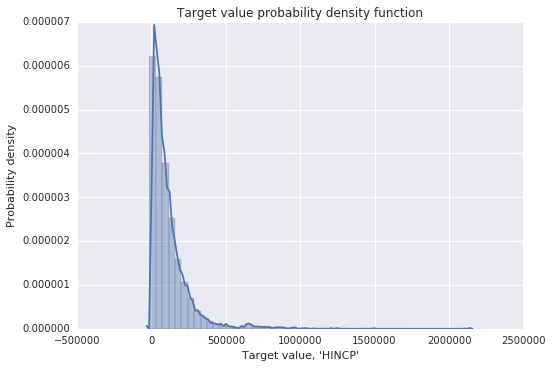

Statistical summary of target variable:
count      30559.000000
mean      113896.404758
std       145755.848572
min       -14762.351200
5%            -9.000000
15.9%      10146.381300
50%        72128.180000
84.1%     200160.431100
95%       356467.362800
max      2138939.169000
Name: HINCP, dtype: float64

First 5 shuffled records for target variable:
18653    158857.48500
19126        -9.00000
16232     73822.98000
27485     93702.05700
12778     65206.78362
Name: HINCP, dtype: float64

Time elapsed (sec) = 0.7


In [29]:
print(
    r"""`df_features`, `ds_target`, `ds_pweight`: Split joined person-housing records into
data frames (series) of features, targets, and person weights. Shuffle the feature columns.
""")
# Note: The data frames (series) are views of `df`, not copies of subsets of `df`.
time_start = time.perf_counter()

# Define columns.
# Define columns for weights.
pweight = 'PWGTP' # person weight
pweights = [pweight+str(inum) for inum in range(1, 81)]
hweight = 'WGTP' # housing weight
hweights = [hweight+str(inum) for inum in range(1, 81)]
weights = [pweight] + pweights + [hweight] + hweights
# Define column for target: household income.
target = 'HINCP'
# Define columns to exclude that...
#     ...are related to the target column household income, e.g.
#         most columns that were adjusted for inflation or others like
#         'POVPIP' = income-to-poverty ratio; 'TAXP' = property taxes.
#     ...don't have a clear interpretation, e.g. 'SRNT' = "specified rent unit".
#     ...are flag versions of excluded columns, e.g. 'FTAXP'
# Note: Individually listed columns were selected from descriptions
#     in the data dictionary `ddict`.
exclude_cols = [target] + adjhsg_cols + adjinc_cols + [
    'POVPIP', 'TAXP', 'OCPIP', 'VALP', 'GRPIP', 'VEH',
    'MRGX', 'MRGT', 'MRGI', 'SMX', 'SRNT', 'SVAL', 'insp']
exclude_cols += ['F'+col for col in exclude_cols]
# Define columns for features that...
#     ...are in the person/housing CSVs or are derived
#     ...aren't weights
#     ...are not an excluded column
# Shuffle feature columns.
features = set(df.columns)
features.difference_update(weights)
features.difference_update(exclude_cols)
features = np.random.permutation(list(features))
if target in features:
    raise AssertionError(
        ("Program error. Target column is in features.\n" +
         "Required: not (target in features)\n" +
         "target={target}").format(target=target))

# Separate data frame into features, target, weights.
# Note: These data frames are views of `df`, not copies of subsets of `df`.
df_features = df[features]
ds_target = df[target]
df_weights = df[weights]
ds_pweight = df[pweight]
print("Number of (rows, columns):")
for (name, obj) in [
    ('df_features', df_features), ('ds_target', ds_target),
    ('df_weights', df_weights), ('ds_pweight', ds_pweight)]:
    print("`{name}`:".format(name=name))
    print("    Number of (rows, columns) = {tup}".format(
        tup=np.shape(obj)))
    if isinstance(obj, pd.DataFrame):
        print("    RAM usage (MB) = {mem:.1f}".format(
            mem=obj.memory_usage().sum()/1e6))
    elif isinstance(obj, pd.Series):
        print("    RAM usage (MB) = {mem:.1f}".format(
            mem=obj.memory_usage()/1e6))
print()

print("Describe target variable:")
print("target: {target}".format(target=target))
for (key0, val0) in ddict['record_types']['HOUSING RECORD'][target].items():
    if isinstance(val0, dict):
        print("    {key}:".format(key=key0))
        for (key1, val1) in val0.items():
            print("        {key}: {val}".format(key=key1, val=val1))
    else:
        print("    {key}: {val}".format(key=key0, val=val0))
# Assert that the number of target values matches the sum of the weights.
# See https://stharrold.github.io/20160110-etl-census-with-python.html
# regarding user verification estimates with weights.
target_vals = list()
for tup in zip(ds_target.values, ds_pweight.astype(int)):
    target_vals += itertools.repeat(*tup)
if not len(target_vals) == ds_pweight.sum():
    raise AssertionError(
        ("Program error. The total number of target values does not equal\n" +
         "the sum of the weights.\n" +
         "Required: len(target_vals) == ds_pweight.sum()\n" +
         "Given: {lhs} == {rhs}").format(
             lhs=len(target_vals), rhs=ds_pweight.sum()))
# Plot histogram of target variable.
sns.distplot(target_vals, hist=True, kde=True, norm_hist=True)
plt.title('Target value probability density function')
plt.xlabel("Target value, '{target}'".format(target=target))
plt.ylabel('Probability density')
plt.show()
print("Statistical summary of target variable:")
print(ds_target.describe(percentiles=percentiles, include='all'))
print()
print("First 5 shuffled records for target variable:")
print(ds_target.head())
print()

time_stop = time.perf_counter()
print("Time elapsed (sec) = {diff:.1f}".format(diff=time_stop-time_start))

## Select features

**TODO:** For blog:
* Task is to use only marginally informative features.
* For examples of feature selection: http://scikit-learn.org/stable/modules/feature_selection.html

In [18]:
print(
    """Perform incremental PCA then Kmeans to create features.
""")
time_start = time.perf_counter()

transformer = sk_dc.IncrementalPCA(whiten=True)
n_digits = len(str(len(df_features.columns)))
components = ['cmp_'+str(inum).rjust(n_digits, '0') for inum in range(len(df_features.columns))]
df_components = pd.DataFrame(
    transformer.fit_transform(X=df_features), index=df_features.index, columns=components)

time_stop = time.perf_counter()
print("Time elapsed (sec) = {diff:.1f}".format(diff=time_stop-time_start))

Perform incremental PCA then Kmeans to create features.

Time elapsed (sec) = 2.7


`df_importances` , `important_features`: Features by importance.
Feature importance is the normalized reduction in the loss score.
A feature is selected as 'important' if its average importance is greater
than the most 'important' random feature. Test significance of predictions
by shuffling the target values. Model scores are R^2, the coefficient of
determination.

Progress: 10% 20% 30% 40% 50% 60% 70% 80% 90% 100% 



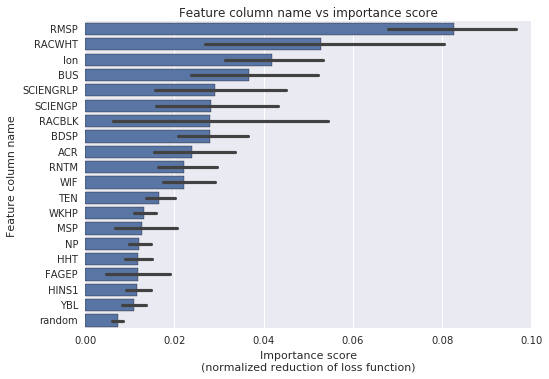


Selected features:
['ACR', 'BDSP', 'BUS', 'FAGEP', 'HHT', 'HINS1', 'MSP', 'NP', 'RACBLK', 'RACWHT', 'RMSP', 'RNTM', 'SCIENGP', 'SCIENGRLP', 'TEN', 'WIF', 'WKHP', 'YBL', 'lon']

Progress: 1% 21% 41% 61% 81% 



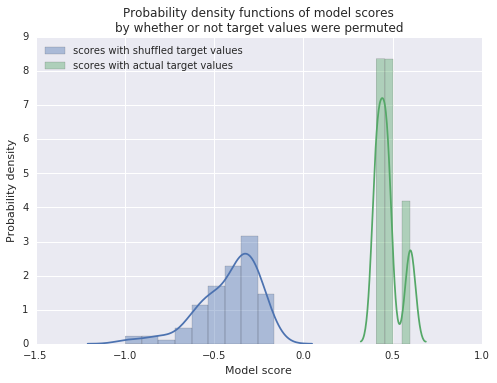

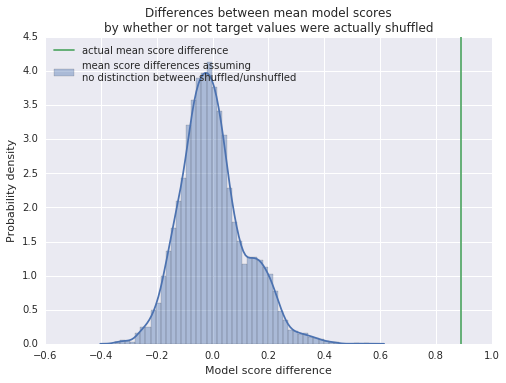

Null hypothesis: There is no distinction in the differences
between the mean model scores whether or not the target
values have been shuffled.
Outcome: Assuming the null hypothesis, the probability of
obtaining a difference between the mean model scores at least
as great as 0.89 is 0.0%.

Time elapsed (sec) = 25.5


In [50]:
print(
    """`df_importances` , `important_features`: Features by importance.
Feature importance is the normalized reduction in the loss score.
A feature is selected as 'important' if its average importance is greater
than the most 'important' random feature. Test significance of predictions
by shuffling the target values. Model scores are R^2, the coefficient of
determination.
""")
time_start = time.perf_counter()

# Note:
#     * `n_estimators` impact the feature importances but only have a small
#         effect on the relative importances.
#     * `n_estimators` impact the scores but only have a small effect on the relative scores.
size_sub = int(3e3)
estimator = sk_ens.ExtraTreesRegressor(n_estimators=10, n_jobs=-1)
df_importances = dsd.ml.calc_feature_importances(
    estimator=estimator, df_features=df_features, ds_target=ds_target,
    ds_weight=ds_pweight, size_sub=size_sub,
    show_progress=True, show_plot=True)
important_features = list(df_importances.columns[
    df_importances.mean() > df_importances['random'].max()])
print()
print("Selected features:")
print(important_features)
print()
dsd.ml.calc_score_pvalue(
    estimator=estimator, df_features=df_features[important_features],
    ds_target=ds_target, ds_weight=ds_pweight, n_iter=100, size_sub=size_sub,
    show_progress=True, show_plot=True)
print()

time_stop = time.perf_counter()
print("Time elapsed (sec) = {diff:.1f}".format(diff=time_stop-time_start))

In [51]:
print("Statistical summary of feature variables:")
print(df_ftrs[ds_ftrs_keep.index].describe(percentiles=percentiles, include='all'))
print()
print("First 5 shuffled records for feature variables:")
print(df_ftrs[ds_ftrs_keep.index].head())
print()
print(r"""Describe feature variables. Format:
Feature: importance score.
Histogram of feature values.""")
for (col, score) in ds_ftrs_keep.items():
    # Describe feature variables.
    print(
        ("{col}:\n" +
         "    importance: {score:.3f}").format(col=col, score=score))
    if col in ddict['record_types']['PERSON RECORD']:
        record_type = 'PERSON RECORD'        
    elif col in ddict['record_types']['HOUSING RECORD']:
        record_type = 'HOUSING RECORD'
    else:
        record_type = 'added'
    if record_type in ['PERSON RECORD', 'HOUSING RECORD']:
        for (key0, val0) in ddict['record_types'][record_type][col].items():
            if isinstance(val0, dict):
                print("    {key}:".format(key=key0))
                for (key1, val1) in val0.items():
                    print("        {key}: {val}".format(key=key1, val=val1))
            else:
                print("    {key}: {val}".format(key=key0, val=val0))
    else:
        print("    description: {desc}".format(desc=ddict_added[col]))
    # Assert that the number of feature values matches the sum of the weights.
    # See https://stharrold.github.io/20160110-etl-census-with-python.html
    # regarding user verification estimates with weights.
    ftr_vals = list()
    for tup in zip(df_ftrs[col].values, ds_pwt.astype(int)):
        ftr_vals += itertools.repeat(*tup)
    if not len(ftr_vals) == ds_pwt.sum():
        raise AssertionError(
            ("Program error. The total number of feature values does not equal the sum of the weights.\n" +
             "Required: len(ftr_vals) == ds_pwt.sum()\n" +
             "Given: {lhs} == {rhs}").format(lhs=len(ftr_vals), rhs=ds_pwt.sum()))
    # Plot histogram of feature variable.
    sns.distplot(ftr_vals, hist=True, kde=True, norm_hist=True)
    plt.title('Feature value probability density function')
    plt.xlabel("Feature value, '{ftr}'".format(ftr=col))
    plt.ylabel('Probability density')
    plt.show()


Statistical summary of feature variables:


NameError: name 'df_ftrs' is not defined

Cluster map of feature correlations with heirarchical relationships.
The deeper of the dendrogram node, the higher (anti)correlated the features are.
The Spearman rank correlation accommodates non-linear features.
The pair plot is a scatter matrix plot of columns vs each other.



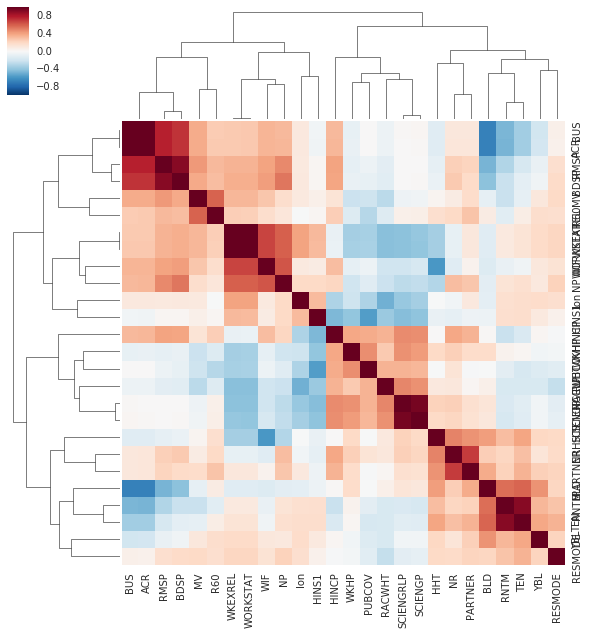

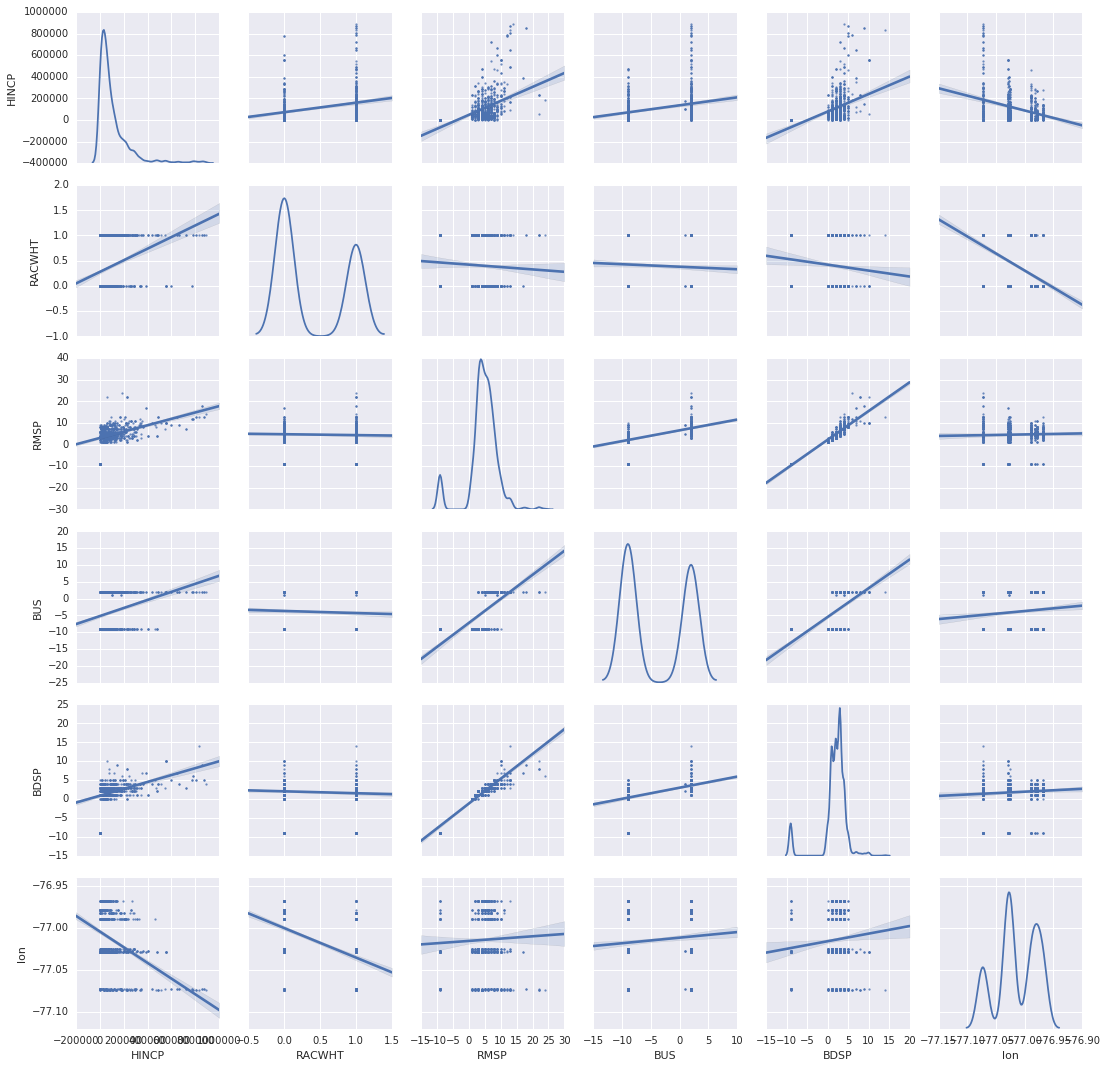

Time elapsed (sec) = 20.5


In [175]:
print(
    """Cluster map of feature correlations with heirarchical relationships.
The deeper of the dendrogram node, the higher (anti)correlated the features are.
The Spearman rank correlation accommodates non-linear features.
The pair plot is a scatter matrix plot of columns vs each other.
""")
time_start = time.perf_counter()

# Score with/without shuffling the target values.
# `pandas` ignores categorical columns when calculating the correlation.
# The order of the clustermap is used for the order of the pairplot.
# Note: The number of records used to validate that the model score is significant
#     only needs to be enough to accurately represent a random process, e.g. 10k.
size_sub = int(1e3)
idxs_wtd_sub = np.random.choice(a=df_ftrs.index, size=size_sub, replace=False)
df_plot_wtd = df_ftrs.loc[idxs_wtd_sub, ds_ftrs_keep.index].copy()
df_plot_wtd[trg] = ds_trg.loc[idxs_wtd_sub]
df_list = list()
for (idx, wt) in ds_pwt.loc[idxs_wtd_sub].items():
    df_list.extend([df_plot_wtd.loc[[idx]]]*int(wt))
df_plot_unwtd = pd.concat(df_list, ignore_index=True, verify_integrity=True)
idxs_unwtd_sub = np.random.choice(a=df_plot_unwtd.index, size=size_sub, replace=False)
df_plot_unwtd_sub = df_plot_unwtd.loc[idxs_unwtd_sub]

cmap = sns.clustermap(df_plot_unwtd_sub.corr(method='spearman'))
plt.show()

pplot = sns.pairplot(
    df_plot_unwtd_sub[pd.Index([trg]).append(ds_ftrs_keep.index[:5])],
    kind='reg', diag_kind='kde', markers='.')
plt.show()

time_stop = time.perf_counter()
print("Time elapsed (sec) = {diff:.1f}".format(diff=time_stop-time_start))

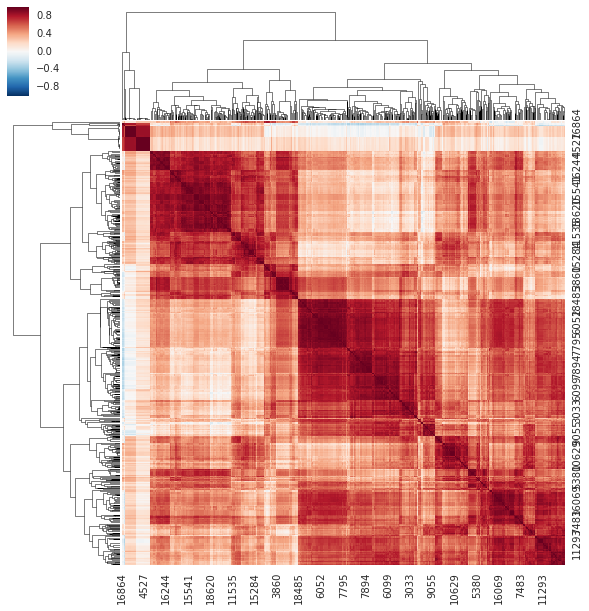

In [178]:
nlabels = int(len(df_plot_unwtd_sub)/20)
sns.clustermap(
    df_plot_unwtd_sub.transpose().corr(method='spearman'),
    xticklabels=nlabels, yticklabels=nlabels)
plt.show()

In [ ]:
### TODO: resume here 20160215
# * Check that spark mlib has this kind of random forest implementation.
# * Tune hyperparameters. Experiment with 'bootstrap' and 'oob_score'.
# * Make into a pipeline.
# * Cross-validate scores of predicted household income.
# * Plot predicted vs actual.
# * Plot marginalized importances.

In [30]:
scores = list()
for n_estimators in n_estimators_list:
    time_start = time.perf_counter()
    print("n_estimators={nest}".format(nest=n_estimators), end='; ')
    estimator = sk_ens.ExtraTreesRegressor(n_estimators=n_estimators, n_jobs=n_jobs)
    estimator.fit(X=df_ftrs_train, y=df_trg_train, sample_weight=ds_pwt_train)
    
    sk_met.r2_score(y_true=ds_trg, y_pred=)
    score = np.mean(sk_cv.cross_val_score(
        estimator=estimator, X=df_ftrs, y=ds_trg, scoring='r2', cv=2, n_jobs=n_jobs))
    scores.append(score)
    print("score={scr:.3f}".format(scr=score))
    time_stop = time.perf_counter()
    print("Time elapsed (sec) = {diff:.1f}".format(diff=time_stop-time_start))

n_estimators=30; 

KeyboardInterrupt: 

In [39]:
test = sk_cv.train_test_split(df_ftrs, ds_trg, test_size=0.2)
np.shape(test[0]), np.shape(test[1])

((24447, 332), (6112, 332))

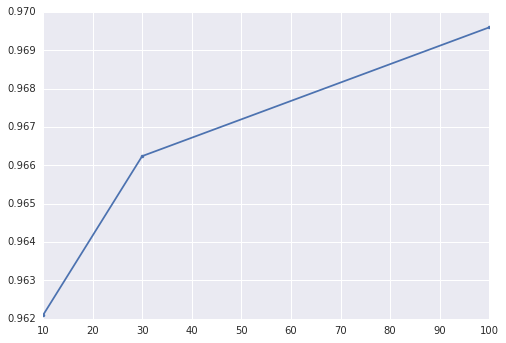

In [28]:
plt.plot(n_estimators_list, scores, marker='.')
plt.show()

In [ ]:
n_jobs = -1
estimator = functools.partial(sk_ens.ExtraTreesRegressor, {'n_jobs': n_jobs})
score = sk_cv.cross_val_score(
    estimator=estimator, X=df_ftrs, y=ds_trg, scoring='r2', cv=5, n_jobs=n_jobs)
score

In [ ]:
model = sk_ens.ExtraTreesRegressor()
model.fit(X=df_ftrs, y=ds_trg)

In [ ]:
model = sk.feature_selection.SelectFromModel(
    estimator=sk_ens.ExtraTreesRegressor(), threshold='mean', prefit=False)
model.fit()

# TODO: redo below

## Select features

**Notes:**
* Example consumer databases: http://www.consumerreports.org/cro/money/consumer-protection/big-brother-is-watching/overview/index.htm?rurl=http%3A%2F%2Fwww.consumerreports.org%2Fcro%2Fmoney%2Fconsumer-protection%2Fbig-brother-is-watching%2Foverview%2Findex.htm
* Random forests are scale invariant, so they can accommodate non-linear transformation.
* Cast all values to floats so that compatable with most algorithms and can use </> logic. Otherwise less informationally dense and may require deeper tree structure to find features.
* To "map to float" ('b' is N/A, mapped to 0; 1 is Yes; 2 is No; other values are special):  
```python
test = pd.DataFrame(data=[['  b', 1.0], ['1', 1.0], ['2', 1.0], ['3', 1.1], ['4', 1.1]], columns=['COL', 'ADJ'])
tfmask = test['COL'].str.contains('b')
test.loc[tfmask, 'COL'] = 0.0
test['COL'] = test['COL'].astype(float)
print(test.dtypes)
test
```
* To "adjust for inflation":  
```python
test['ADJ'] *= 1e-6
tfmask = test['COL'] >= 3.0
test.loc[tfmask, 'COL'] *= test.loc[tfmask, 'ADJ']
test
```
* TODO: Remove vacant units ('NP') from data frame.
* TODO: Filter categorical variables from metadata (those without '..').

In [66]:
record_type = 'PERSON RECORD'
print_detail = False
for key in ddict['record_types'][record_type]:
    desc = ddict['record_types'][record_type][key]['description']
    if not (
        (key.startswith('F') and (desc.endswith(' flag') or desc.endswith(' edit')))
        or ('WGTP' in key and "Weight replicate" in desc)):
        if print_detail:
            print(key)
            pprint.pprint(ddict['record_types'][record_type][key])
        else:
            print("{key}: {desc}".format(key=key, desc=desc))

RT: Record Type
SERIALNO: Housing unit/GQ person serial number
SPORDER: Person number
PUMA00: Public use microdata area code (PUMA) based on Census 2000 definition for data collected prior to 2012. Use in combination with PUMA10.
PUMA10: Public use microdata area code (PUMA) based on 2010 Census definition for data Collected in 2012 or later. Use in combination with PUMA00.
ST: State Code
ADJINC: Adjustment factor for income and earnings dollar amounts (6 implied decimal places)
PWGTP: Person's weight
AGEP: Age
CIT: Citizenship status
CITWP05: Year of naturalization write-in for data collected prior to 2012
CITWP12: Year of naturalization write-in for data collected in 2012 or later
COW: Class of worker
DDRS: Self-care difficulty
DEAR: Hearing difficulty
DEYE: Vision difficulty
DOUT: Independent living difficulty
DPHY: Ambulatory difficulty
DRAT: Veteran service connected disability rating (percentage)
DRATX: Veteran service connected disability rating (checkbox)
DREM: Cognitive diffic

In [85]:
# Include columns that I think companies can easily get.
# for column details: https://www.census.gov/programs-surveys/acs/technical-documentation/pums/documentation.2013.html
# target: HINCP

cols_include = {
    'HOUSING RECORD': [
        'SERIALNO', 'PUMA00', 'PUMA10', 'ST', 'ADJHSG', 'ADJINC', 'WGTP', 'NP', 'BDSP', 'BLD', 'HINCP', 'R18', 'R65'],
    'PERSON RECORD': [
        'SERIALNO', 'SPORDER', 'PWGTP', 'AGEP', 'MAR', 'SCHL', 'INDP']
    }

In [86]:
for record_type in cols_include:
    print(record_type)
    for var_name in cols_include[record_type]:
        desc = ddict['record_types'][record_type][var_name]['description']
        print("{var}: {desc}".format(var=var_name, desc=desc))
    print()

HOUSING RECORD
SERIALNO: Housing unit/GQ person serial number
PUMA00: Public use microdata area code (PUMA) based on Census 2000 definition for data collected prior to 2012. Use in combination with PUMA10.
PUMA10: Public use microdata area code (PUMA) based on 2010 Census definition for data collected in 2012 or later. Use in combination with PUMA00.
ST: State Code
ADJHSG: Adjustment factor for housing dollar amounts (6 implied decimal places)
ADJINC: Adjustment factor for income and earnings dollar amounts (6 implied decimal places)
WGTP: Housing Weight
NP: Number of person records following this housing record
BDSP: Number of bedrooms
BLD: Units in structure
HINCP: Household income (past 12 months)
R18: Presence of persons under 18 years in household (unweighted)
R65: Presence of persons 65 years and over in household (unweighted)

PERSON RECORD
SERIALNO: Housing unit/GQ person serial number
SPORDER: Person number
PWGTP: Person's weight
AGEP: Age
MAR: Marital status
SCHL: Educational

In [80]:
record_type = 'PERSON RECORD'
var_codes = ddict['record_types'][record_type]['INDP']['var_codes']
indp_abbr = dict()
for var_code in var_codes.keys():
    indp_abbr[var_code] = var_codes[var_code].split(sep='-', maxsplit=1)[0][:3]
print(sorted(set(indp_abbr.values())))

['ADM', 'AGR', 'CON', 'EDU', 'ENT', 'EXT', 'FIN', 'INF', 'MED', 'MFG', 'MIL', 'Not', 'PRF', 'RET', 'SCA', 'SRV', 'TRN', 'UNE', 'UTL', 'WHL']


Actions for included columns:  
* HOUSING RECORD
    * SERIALNO: Use to join to PERSON RECORD.
    * PUMA00, PUMA10, ST: Combine and lookup lat-lon coordinates from census.gov.
    * ADJHSG, ADJINC: Multiply against other columns to adjust for inflation. See https://www.census.gov/library/publications/2009/acs/pums.html App 5.
    ADJHSG: CONP, ELEP, FULP, GASP, GRNTP, INSP, MHP, MRGP, SMOCP, RNTP, SMP, WATP
    ADJINC: INTP, OIP, PAP, PERNP, PINCP, RETP, SEMP, SSIP, SSP, WAGP
    * WGTP: Confirm with user verification file.
    * NP: Numerical. Map to float.
    * BDSP: Numerical. Map to float.
    * BLD: Map to median income.
    * HINCP: Include. Map household income to float. Adjust all with ADJINC.
    * R18: Include. Presence of persons under 18 years in household. Map to float.
    * R65: Include. Presence of persons 60+ years in household.
* PERSON RECORD
    * SERIALNO, SPORDER: Use as index.
    * PWGTP: Confirm user verification file.
    * AGEP: Map to float.
    * MAR: Map to float.
    * SCHL: Map to float.
    * INDP: (1) Map to float. (2) Map categories to median income.

## Export ipynb to html

In [158]:
!date --rfc-3339='seconds'

2016-01-01 05:40:17+00:00


In [ ]:
path_ipynb = os.path.join(path_static, basename, basename+'.ipynb')
for template in ['basic', 'full']:
    path_html = os.path.splitext(path_ipynb)[0]+'-'+template+'.html'
    cmd = ['jupyter', 'nbconvert', '--to', 'html', '--template', template, path_ipynb, '--output', path_html]
    print(' '.join(cmd))
    subprocess.run(args=cmd, check=True)